### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Directorio de imágenes

In [2]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

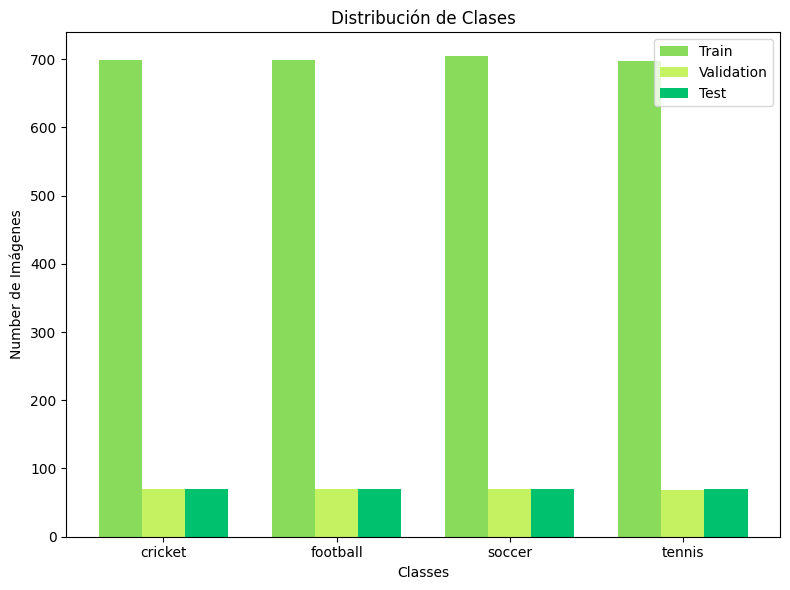

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Obtener conteo de clases
train_counts = Counter(train_generator.classes)
val_counts = Counter(validation_generator.classes)
test_counts = Counter(test_generator.classes)

# Ordenar las etiquetas (según índice)
class_indices = train_generator.class_indices
labels = list(class_indices.keys())
labels.sort()  # aseguramos que el orden sea consistente

# Valores por clase en orden
train_values = [train_counts[i] for i in range(len(labels))]
val_values = [val_counts[i] for i in range(len(labels))]
test_values = [test_counts[i] for i in range(len(labels))]

# Crear gráfico de barras agrupadas
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(x - width, train_values, width, label='Train', color='#89DB5C')  
plt.bar(x, val_values, width, label='Validation', color='#C4F261')       
plt.bar(x + width, test_values, width, label='Test', color='#00C26E') 
plt.xlabel('Classes')
plt.ylabel('Number de Imágenes')
plt.title('Distribución de Clases')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


### Escalamiento y Preprocesado

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Escalar a [0, 1]
    rotation_range=30,
    width_shift_range=0.1,         
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    brightness_range=[0.8, 1.1], 
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Escalar validation a [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)  # Escalar test a [0, 1]

In [5]:
# Generators
# Cargar imágenes de las carpetas y redimencionarlas

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (150, 150),
	batch_size = 8,  
	class_mode ='categorical', # 'categorical' para más de 2 clases a clasificar
	shuffle = True 
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2797 images belonging to 4 classes.
Found 279 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


<Figure size 640x480 with 0 Axes>

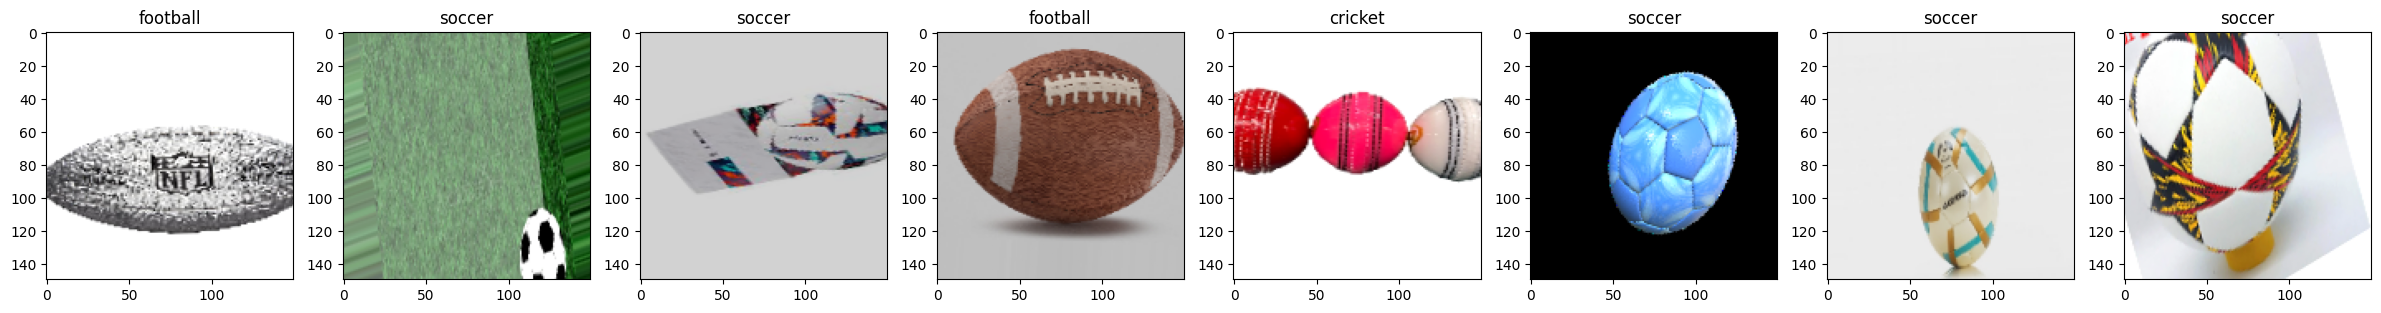

In [6]:
# Visualizar imágenes despúes de escalamiento y preprocesado
images, labels = train_generator[0]

class_names = list(train_generator.class_indices.keys()) # Obtener nombres de clases
label_indices = labels.argmax(axis=1)  # Convierte etiquetas a índices

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]):
    axarr[i].imshow(images[i])
    axarr[i].set_title(class_names[label_indices[i]], fontsize=12)

### Implementación del Modelo: Inspirado en la arquitectura ICNN-BNDOA

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers

def get_model_deep(input_shape, num_classes=4):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

In [8]:
num_classes = train_generator.num_classes

model = get_model_deep((150, 150, 3), num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

In [9]:
def train_model_deep(model, train_generator, validation_generator):
    history = model.fit(train_generator, epochs=50, validation_data=validation_generator)
    return history
    
history = train_model_deep(model, train_generator, validation_generator)

Epoch 1/50
350/350 [==============================] - 21s 59ms/step - loss: 1.2006 - accuracy: 0.4537 - val_loss: 0.9870 - val_accuracy: 0.6201
Epoch 2/50
350/350 [==============================] - 19s 55ms/step - loss: 0.9889 - accuracy: 0.5989 - val_loss: 0.9337 - val_accuracy: 0.5806
Epoch 3/50
350/350 [==============================] - 19s 55ms/step - loss: 0.9384 - accuracy: 0.6335 - val_loss: 0.9103 - val_accuracy: 0.6165
Epoch 4/50
350/350 [==============================] - 19s 55ms/step - loss: 0.8880 - accuracy: 0.6654 - val_loss: 0.8838 - val_accuracy: 0.6774
Epoch 5/50
350/350 [==============================] - 20s 58ms/step - loss: 0.8610 - accuracy: 0.6814 - val_loss: 0.8766 - val_accuracy: 0.6452
Epoch 6/50
350/350 [==============================] - 29s 82ms/step - loss: 0.8255 - accuracy: 0.6893 - val_loss: 0.8307 - val_accuracy: 0.6523
Epoch 7/50
350/350 [==============================] - 35s 100ms/step - loss: 0.8017 - accuracy: 0.7008 - val_loss: 0.7860 - val_accuracy

In [15]:
# Guardar modelo
model.save('mi_modelo.h5')

# Guardar history
import pickle
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [79]:
# Cargar modelo guardado
from tensorflow.keras.models import load_model
import pickle

model = load_model("mi_modelo.h5")

with open("history.pkl", "rb") as f:
    history_dict = pickle.load(f)

### Evaluación del Modelo

In [10]:
from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de métricas
print("Reporte:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))



9/9 [==============================] - 1s 136ms/step
Reporte:

              precision    recall  f1-score   support

     cricket       0.76      0.93      0.83        70
    football       0.98      0.86      0.92        70
      soccer       0.93      0.81      0.87        70
      tennis       0.88      0.90      0.89        70

    accuracy                           0.88       280
   macro avg       0.89      0.87      0.88       280
weighted avg       0.89      0.88      0.88       280



#### Gráfica Val vs. Tran

In [11]:
results = model.evaluate(test_generator)

print('\nTest loss:', results[0])
print('Test accuracy:', results[1])

9/9 [==============================] - 1s 107ms/step - loss: 0.4036 - accuracy: 0.8750

Test loss: 0.40361255407333374
Test accuracy: 0.875


9/9 [==============================] - 1s 122ms/step - loss: 0.4036 - accuracy: 0.8750


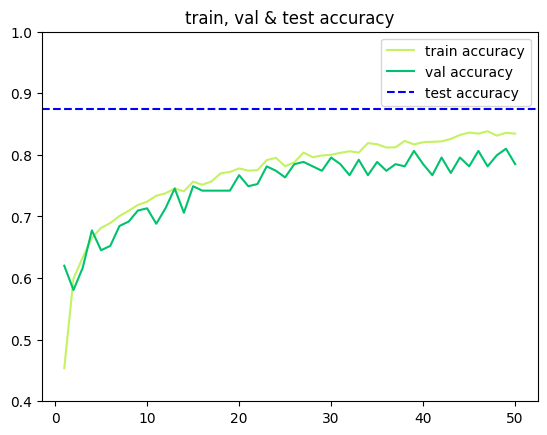

9/9 [==============================] - 1s 93ms/step - loss: 0.4036 - accuracy: 0.8750


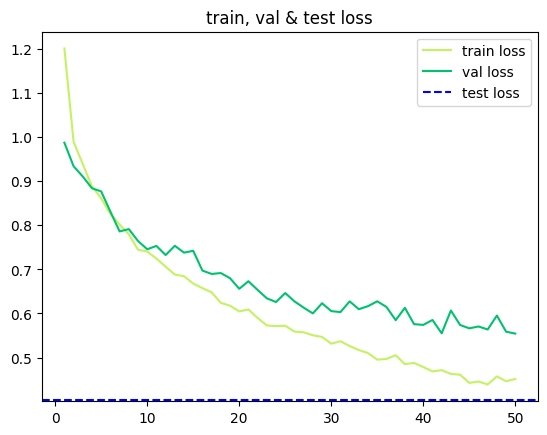

In [26]:
# Accuracy
test_loss, test_acc = model.evaluate(test_generator)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='train accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='val accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='test accuracy')
plt.title('train, val & test accuracy')
plt.ylim(0.4, 1)
plt.legend()
plt.show()

# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

results = model.evaluate(test_generator)
test_loss = results[0]  

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='train loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='val loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='test loss')

plt.title('train, val & test loss')
plt.legend()
plt.show()

9/9 [==============================] - 1s 110ms/step


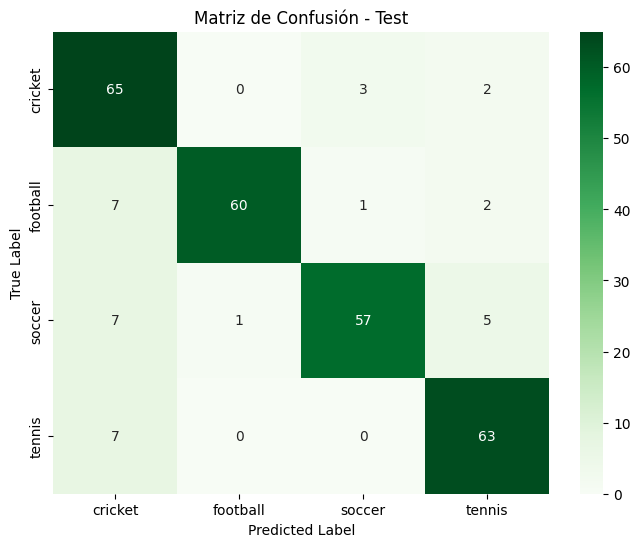

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas del generador
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()